In [ ]:
import re
import os
import sys
import string
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from get_data import get_data
from Constants import Constants

c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top
c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\transformers\cache_utils.py:1918: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  offload_device: Union[str, torch.device] = torch.device("cpu"),


In [2]:
print("TensorFlow is using GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = get_data(Constants.turkish_news_article_path, encoding="utf-16")

In [4]:
data.tail()

,Görüş,Durum
11424,biraz fazla ısınıyor ama sorumsuz çalışıyor,Tarafsız
11425,orijinal ürün fakat ambalaj bize ulaşana kadar...,Tarafsız
11426,bu cihazı 1 yıldır kullanıyorum cihazı çok beğ...,Olumsuz
11427,Bir sene olmadı ayar düğmesine basıyorum ekran...,Tarafsız
11428,Urun kaliteli zamaninda tedlimat ve kullanisli...,Olumlu


In [5]:
data.Durum.value_counts()

Olumlu      4253
Olumsuz     4238
Tarafsız    2938
Name: Durum, dtype: int64

In [ ]:
data.isnull().sum()

Görüş    3
Durum    0
dtype: int64

In [7]:
data = data.dropna()
data.isnull().sum()

Görüş    0
Durum    0
dtype: int64

In [8]:
data.describe(include='all')

,Görüş,Durum
count,11426,11426
unique,11407,3
top,İdare eder,Olumlu
freq,3,4252


In [9]:
data = data.rename(columns={"Görüş": "text", "Durum": "label"})

In [10]:
data.text.duplicated(keep="first").value_counts()

False    11407
True        19
Name: text, dtype: int64

In [11]:
data = data.drop_duplicates(subset="text", keep="first", ignore_index=True)
data.describe()

,text,label
count,11407,11407
unique,11407,3
top,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumlu
freq,1,4244


In [12]:
data.label.unique()

array(['Olumsuz', 'Tarafsız', 'Olumlu'], dtype=object)

In [13]:
label_list = data.label.unique()

In [14]:
data.label.value_counts()

Olumlu      4244
Olumsuz     4234
Tarafsız    2929
Name: label, dtype: int64

<AxesSubplot:>

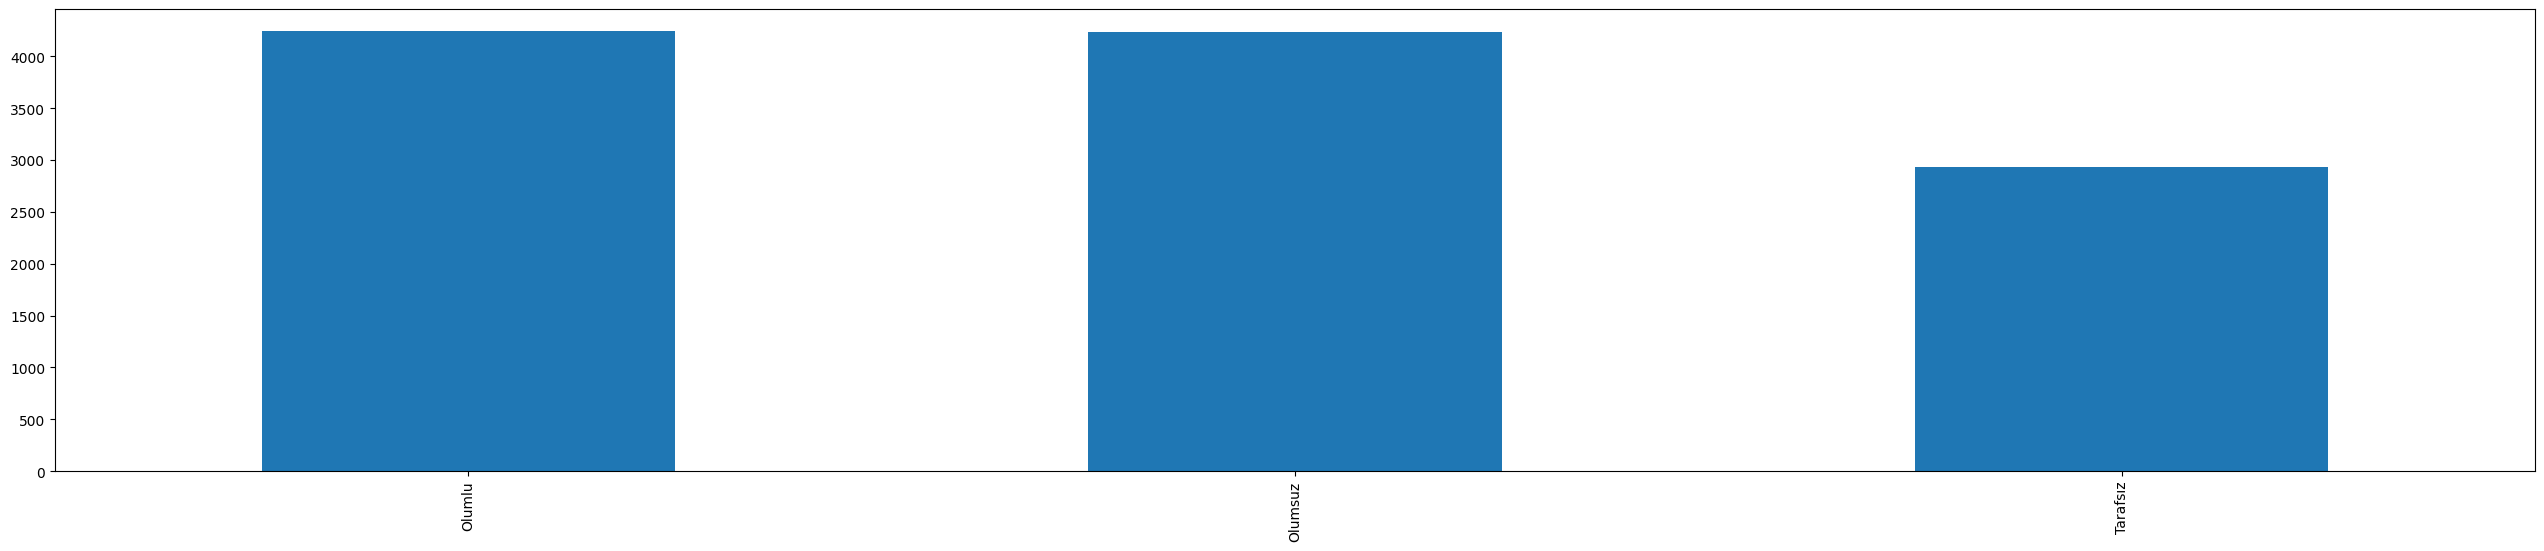

In [15]:
data.label.value_counts().plot.bar(x="Labels",y="Number of Texts",figsize=(32,6))

In [16]:
data['words'] = [len(x.split()) for x in data['text'].tolist()]

In [17]:
data[['words','text']].head()

,words,text
0,24,"ses kalitesi ve ergonomisi rezalet, sony olduğ..."
1,3,hizli teslimat tesekkürler
2,20,ses olayı süper....gece çalıştır sıkıntı yok.....
3,7,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,56,Kulaklığın sesi kaliteli falan değil. Aleti öv...


In [18]:
data['words'].describe()

count    11407.000000
mean        21.894100
std         24.434362
min          1.000000
25%          7.000000
50%         14.000000
75%         28.000000
max        422.000000
Name: words, dtype: float64

In [19]:
data.query('words < 3').head(20)

,text,label,words
6,kullanisli baya,Olumlu,2
44,kullanmadım daha,Tarafsız,2
65,Kesinlikle beğenmedim,Olumsuz,2
81,Güzel ilgileniyorlar.,Olumsuz,2
109,idare eder,Olumsuz,2
160,Hızlı deyil....,Olumsuz,2
338,Çok mennunum,Olumlu,2
410,çayı süper..,Olumlu,2
461,Kötü,Olumsuz,1
470,Beğenmedim ürününüzü.,Tarafsız,2


In [20]:
len(data)

11407

In [21]:
len(data.query('words > 100'))

183

In [22]:
data.groupby(['label'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Olumlu,4244.0,16.929312,19.480774,1.0,6.0,10.0,21.00,284.0
Olumsuz,4234.0,24.693906,26.409688,1.0,9.0,17.0,31.75,422.0
Tarafsız,2929.0,25.040628,26.655553,1.0,9.0,18.0,31.00,339.0


In [23]:
len(data.query('words > 50'))

962

In [24]:
len(data.query('words > 80'))

317

In [25]:
max_text_size = 100

In [26]:
data = data[data['words'] <= max_text_size]

In [27]:
data = data.reset_index(drop=True)

In [28]:
data.count()

text     11224
label    11224
words    11224
dtype: int64

In [29]:
word_freq= data.text.str.split(expand=True).stack().value_counts()
word_freq=word_freq.reset_index(name='freq').rename(columns={'index': 'word'})
top_20_frequent_words = word_freq[:20]
top_20_frequent_words

,word,freq
0,bir,4294
1,çok,3891
2,ve,3487
3,ürün,2110
4,ama,1942
5,iyi,1739
6,bu,1723
7,için,1676
8,güzel,1546
9,daha,1412


# PREPARE THE DATASET

## Custom Standardization

In [30]:
tr_stopwords = get_data(Constants.tr_stopwords_path, header=None)

In [31]:
tr_stopwords.head()

,0
0,ama
1,amma
2,anca
3,ancak
4,bu


In [32]:
def custom_standardization(input_string):
    """Remove HTML line-break tags, handle punctuation, remove stopwords, and normalize text."""
    # Lowercase the text
    no_uppercased = input_string.lower()
    
    # Replace asterisks with space
    no_stars = re.sub(r"\*", " ", no_uppercased)
    
    # Remove HTML tags
    no_html = re.sub(r"<br\s*/?>", "", no_stars)
    
    # Remove words containing digits
    no_digits = re.sub(r"\w*\d\w*", "", no_html)
    
    # Remove punctuations
    no_punctuations = re.sub(f"[{re.escape(string.punctuation)}]", " ", no_digits)
    
    # Remove extra spaces
    no_extra_space = re.sub(r"\s+", " ", no_punctuations).strip()
    
    # Normalize Turkish characters
    no_I = no_extra_space.replace("ı", "i")
    no_O = no_I.replace("ö", "o")
    no_C = no_O.replace("ç", "c")
    no_S = no_C.replace("ş", "s")
    no_G = no_S.replace("ğ", "g")
    no_U = no_G.replace("ü", "u")
    
    # Remove stopwords using regex
    no_stop_words = no_U
    for stopword in tr_stopwords[0]:
        no_stop_words = re.sub(rf"\b{stopword}\b", "", no_stop_words)
    
    # Remove any extra spaces again after removing stopwords
    cleaned_text = re.sub(r"\s+", " ", no_stop_words).strip()
    
    return cleaned_text

In [33]:
data["text"] = data["text"].apply(custom_standardization)

In [34]:
data.tail()

,text,label,words
11219,fazla isiniyor sorumsuz calisiyor,Tarafsız,6
11220,orijinal urun ambalaj bize ulasana param parca...,Tarafsız,10
11221,cihazi yildir kullaniyorum cihazi cok begenere...,Olumsuz,31
11222,sene olmadi ayar dugmesine basiyorum ekran gid...,Tarafsız,9
11223,urun kaliteli zamaninda tedlimat kullanisli ko...,Olumlu,10


In [35]:
word_freq= data.text.str.split(expand=True).stack().value_counts()
word_freq=word_freq.reset_index(name='freq').rename(columns={'index': 'word'})
top_20_frequent_words = word_freq[:20]
top_20_frequent_words

,word,freq
0,cok,5301
1,urun,4229
2,guzel,2208
3,iyi,2193
4,icin,1920
5,aldim,1325
6,tavsiye,1273
7,urunu,1223
8,degil,1201
9,geldi,987


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11224 entries, 0 to 11223
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11224 non-null  object
 1   label   11224 non-null  object
 2   words   11224 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 263.2+ KB


In [37]:
data.describe()

,words
count,11224.000000
mean,19.881415
std,17.704790
min,1.000000
25%,7.000000
50%,14.000000
75%,27.000000
max,100.000000


In [38]:
data = data.sample(frac=1)

In [39]:
data["label"] = data["label"].astype('category')
data.dtypes

text       object
label    category
words       int64
dtype: object

In [40]:
data["LabelId"] = data["label"].cat.codes

In [41]:
data.tail()

,text,label,words,LabelId
8657,cabuk isiniyor boyutundan dolayi yer kaplamiyo...,Olumlu,23,0
8732,kalite zamaninda sevkiyat fiyati cok iyi bilgi...,Tarafsız,31,2
9242,annemin elektrikli supurgeye ihtiyaci vardi ar...,Olumlu,77,0
6684,yorumlara bakarak almistim utunun performansi ...,Tarafsız,13,2
9764,urunde asiri siklik beklemeyin montaj yaparken...,Olumsuz,36,1


In [42]:
data.dtypes

text         object
label      category
words         int64
LabelId        int8
dtype: object

In [43]:
id_to_label = pd.Series(data.label.values,index=data.LabelId).to_dict()
id_to_label

{1: 'Olumsuz', 0: 'Olumlu', 2: 'Tarafsız'}

In [44]:
label_to_id= {v:k for k,v in id_to_label.items()}
label_to_id

{'Olumsuz': 1, 'Olumlu': 0, 'Tarafsız': 2}

In [ ]:
import pickle
with open('id_to_label_data1.pkl', 'wb') as fp:
    pickle.dump(id_to_label, fp)

In [46]:
with open('label_to_id_data1.pkl', 'wb') as fp:
    pickle.dump(label_to_id, fp)

## Split Dataset

In [47]:
texts = data['text']  # Metinlerin olduğu sütun
labels = data['LabelId']  # Etiketlerin olduğu sütun

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, 
    test_size=0.2, 
    random_state=42,
    shuffle = True,
    stratify=labels
)

In [48]:
print("Train Data Set size: ",len(train_texts))
print("Test Data Set size: ",len(test_texts))

Train Data Set size:  8979
Test Data Set size:  2245


# Embeddings

In [49]:
def get_embeddings(model_name, texts, batch_size=32):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModel.from_pretrained(model_name, trust_remote_code=True)  # trust_remote_code parametresi eklendi
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="tf")
        outputs = model(**tokens)
        # Pooling işlemi (örnek olarak mean pooling kullanıyoruz)
        embeddings.append(tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy())
    
    return np.vstack(embeddings)


In [50]:
models = [
    "dbmdz/bert-base-turkish-uncased",
    "sentence-transformers/all-MiniLM-L12-v2",
    "intfloat/multilingual-e5-large-instruct",
    "dbmdz/electra-base-turkish-cased-discriminator",
    "cardiffnlp/twitter-xlm-roberta-base"
]

train_embeddings = {}
test_embeddings = {}

for model_name in models:
    print(f"Processing model: {model_name}")
    train_embeddings[model_name] = get_embeddings(model_name, train_texts.tolist())
    test_embeddings[model_name] = get_embeddings(model_name, test_texts.tolist())


Processing model: dbmdz/bert-base-turkish-uncased


Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 281/281 [00:22<00:00, 12.71it/s]
Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not use

Processing model: sentence-transformers/all-MiniLM-L12-v2


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|██████████| 281/281 [00:20<00:00, 13.68it/s]
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are 

Processing model: intfloat/multilingual-e5-large-instruct


All PyTorch model weights were used when initializing TFXLMRobertaModel.

All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 281/281 [01:04<00:00,  4.34it/s]
All PyTorch model weights were used when initializing TFXLMRobertaModel.

All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 71/71 [00:16<00:00,  4.21it/s]


Processing model: dbmdz/electra-base-turkish-cased-discriminator


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.
100%|██████████| 281/281 [00:2

Processing model: cardiffnlp/twitter-xlm-roberta-base


All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 281/281 [00:23<00:00, 12.02it/s]
All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
100%|██████████| 71/71 [00:06<00:00, 11.77it/s]


# Model

In [ ]:
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Sınıflandırıcılar
classifiers = {
    "SVM": SVC,
    "RandomForest": RandomForestClassifier,
    "MLP": MLPClassifier
}

# Eğitimli modelleri saklamak için
trained_classifiers = {model_name: {} for model_name in train_embeddings.keys()}
all_predictions = {model_name: {} for model_name in train_embeddings.keys()}

# Eğitim ve sonuçları toplama
results = []
for model_name, train_embed in train_embeddings.items():
    for clf_name, clf_class in classifiers.items():
        print(f"Training {clf_name} with {model_name}")
        
        # Her döngüde yeni bir sınıflandırıcı oluştur ve eğit
        clf = clf_class()
        clf.fit(train_embed, train_labels)
        
        # Eğitimli modeli ve tahminlerini sakla
        trained_classifiers[model_name][clf_name] = clf
        predictions = clf.predict(test_embeddings[model_name])
        all_predictions[model_name][clf_name] = predictions
        
        # Metriği hesapla ve kaydet
        acc = accuracy_score(test_labels, predictions)
        f1 = f1_score(test_labels, predictions, average="weighted")
        
        results.append({
            "Representation": model_name,
            "Classifier": clf_name,
            "Accuracy": acc,
            "F1-Score": f1
        })

results_df = pd.DataFrame(results)


Training SVM with dbmdz/bert-base-turkish-uncased
Training RandomForest with dbmdz/bert-base-turkish-uncased
Training MLP with dbmdz/bert-base-turkish-uncased
Training SVM with sentence-transformers/all-MiniLM-L12-v2
Training RandomForest with sentence-transformers/all-MiniLM-L12-v2
Training MLP with sentence-transformers/all-MiniLM-L12-v2


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVM with intfloat/multilingual-e5-large-instruct
Training RandomForest with intfloat/multilingual-e5-large-instruct
Training MLP with intfloat/multilingual-e5-large-instruct


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVM with dbmdz/electra-base-turkish-cased-discriminator
Training RandomForest with dbmdz/electra-base-turkish-cased-discriminator
Training MLP with dbmdz/electra-base-turkish-cased-discriminator


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SVM with cardiffnlp/twitter-xlm-roberta-base
Training RandomForest with cardiffnlp/twitter-xlm-roberta-base
Training MLP with cardiffnlp/twitter-xlm-roberta-base


c:\Users\User\OneDrive\Belgeler\OKUL\Kollektif\odev_1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:
results_df

,Representation,Classifier,Accuracy,F1-Score
0,dbmdz/bert-base-turkish-uncased,SVM,0.718486,0.703855
1,dbmdz/bert-base-turkish-uncased,RandomForest,0.679287,0.651892
2,dbmdz/bert-base-turkish-uncased,MLP,0.672160,0.671535
3,sentence-transformers/all-MiniLM-L12-v2,SVM,0.633408,0.604983
4,sentence-transformers/all-MiniLM-L12-v2,RandomForest,0.563920,0.516770
5,sentence-transformers/all-MiniLM-L12-v2,MLP,0.590200,0.588179
6,intfloat/multilingual-e5-large-instruct,SVM,0.728731,0.712504
7,intfloat/multilingual-e5-large-instruct,RandomForest,0.697996,0.661601
8,intfloat/multilingual-e5-large-instruct,MLP,0.673497,0.651493
9,dbmdz/electra-base-turkish-cased-discriminator,SVM,0.617372,0.535566


In [65]:
results_df.groupby("Representation")[["F1-Score"]].mean()

,F1-Score
Representation,
cardiffnlp/twitter-xlm-roberta-base,0.609865
dbmdz/bert-base-turkish-uncased,0.675761
dbmdz/electra-base-turkish-cased-discriminator,0.573155
intfloat/multilingual-e5-large-instruct,0.675199
sentence-transformers/all-MiniLM-L12-v2,0.569977


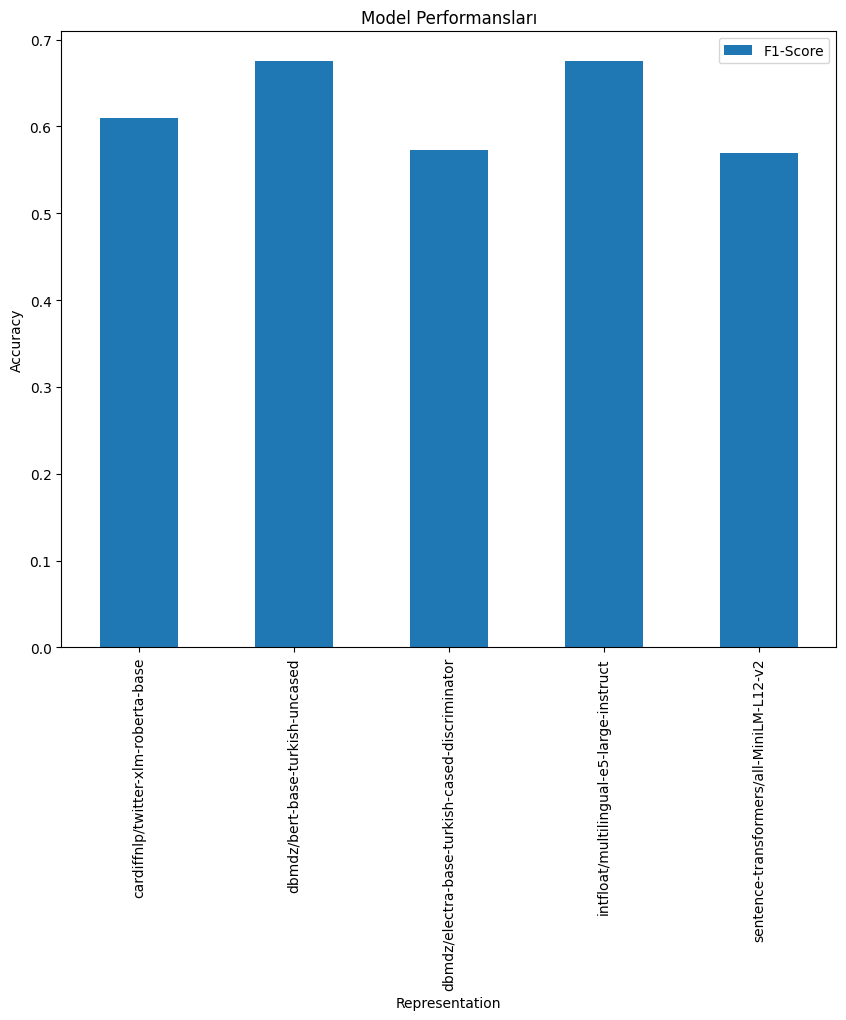

In [54]:
results_df.groupby("Representation")[["F1-Score"]].mean().plot(kind="bar", figsize=(10, 8))
plt.title("Model Performansları")
plt.ylabel("Accuracy")
plt.show()

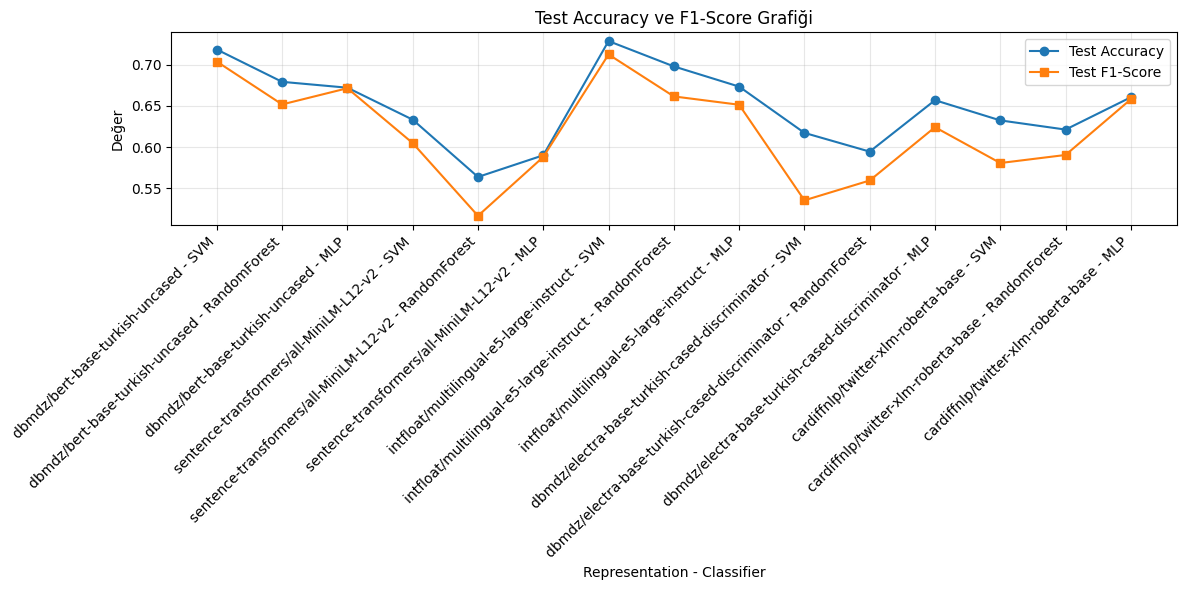

In [56]:
# Test Accuracy ve F1-Score değerlerini çizgi grafiğiyle görselleştirme
plt.figure(figsize=(12, 6))

# Test Accuracy çizgisi
plt.plot(
    results_df["Representation"] + " - " + results_df["Classifier"],  # Model ve sınıflandırıcı isimleri
    results_df["Accuracy"],
    marker='o',
    label="Test Accuracy"
)

# Test F1-Score çizgisi
plt.plot(
    results_df["Representation"] + " - " + results_df["Classifier"],
    results_df["F1-Score"],
    marker='s',
    label="Test F1-Score"
)

# Grafik detayları
plt.xticks(rotation=45, ha='right')  # X eksenindeki model isimlerini döndürme
plt.title("Test Accuracy ve F1-Score Grafiği")
plt.xlabel("Representation - Classifier")
plt.ylabel("Değer")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Grafiği gösterme
plt.show()


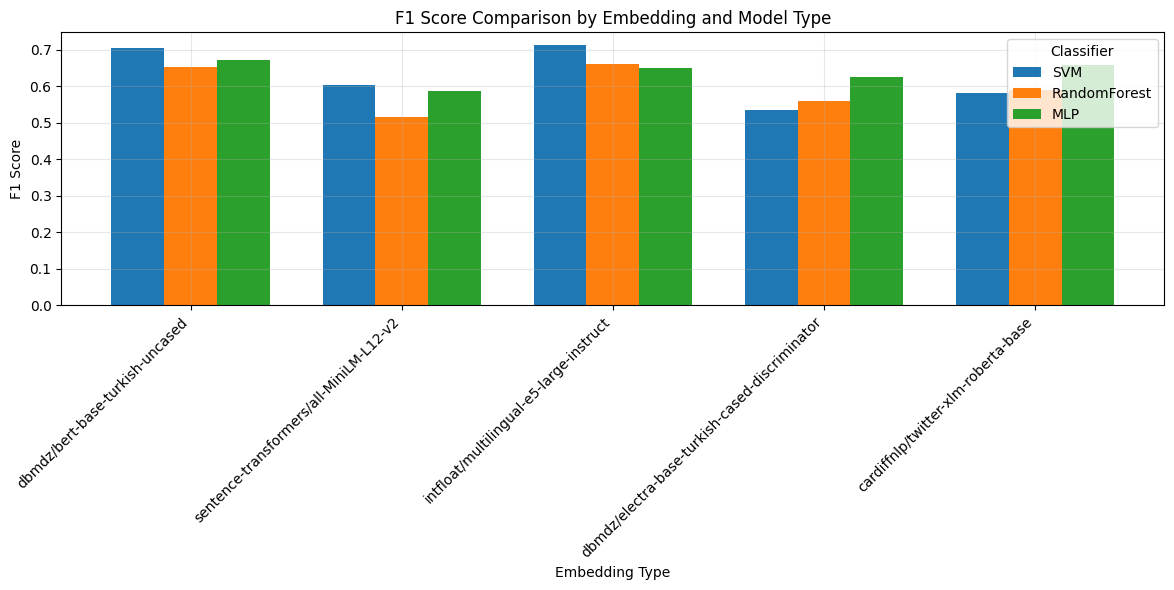

In [57]:
# Verileri hazırlama
embedding_types = results_df["Representation"].unique()  # Embedding türleri
unique_classifiers = results_df["Classifier"].unique()  # Sınıflandırıcı türleri

# Gruplar bazında F1 skorlarını hesaplama
f1_scores = []
for embedding in embedding_types:
    scores = []
    for clf in unique_classifiers:
        # Her embedding ve sınıflandırıcı kombinasyonu için F1 skorunu al
        score = results_df[
            (results_df["Representation"] == embedding) & (results_df["Classifier"] == clf)
        ]["F1-Score"].values[0]
        scores.append(score)
    f1_scores.append(scores)

f1_scores = np.array(f1_scores)  # Listeyi numpy dizisine çevir

# Bar grafiği için gerekli ayarlar
x = np.arange(len(embedding_types))  # Embedding türleri için x ekseni pozisyonları
bar_width = 0.25  # Bar genişliği

# Grafik çizimi
fig, ax = plt.subplots(figsize=(12, 6))

for i, clf in enumerate(unique_classifiers):
    ax.bar(
        x + i * bar_width,
        f1_scores[:, i],
        width=bar_width,
        label=clf
    )

# X ekseni ve başlıklar
ax.set_xticks(x + bar_width)
ax.set_xticklabels(embedding_types, rotation=45, ha='right')
ax.set_title("F1 Score Comparison by Embedding and Model Type")
ax.set_xlabel("Embedding Type")
ax.set_ylabel("F1 Score")
ax.legend(title="Classifier")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

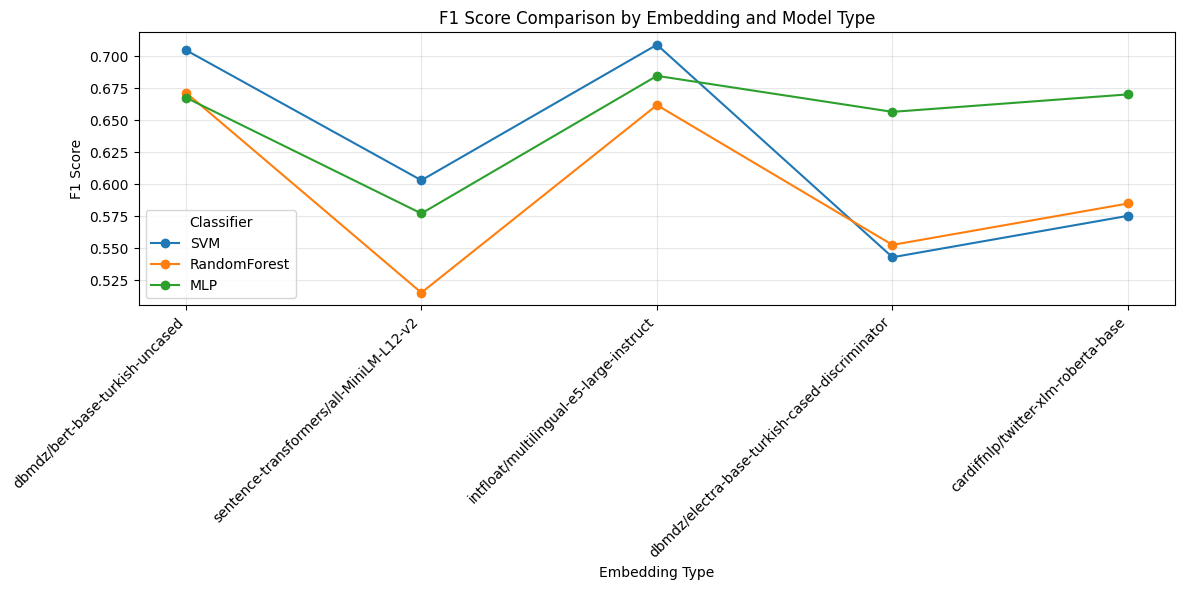

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))

# Her sınıflandırıcı için F1 skorları
for i, clf in enumerate(unique_classifiers):
    ax.plot(
        embedding_types,
        f1_scores[:, i],
        marker='o',
        label=clf
    )

ax.set_xticks(range(len(embedding_types)))
ax.set_xticklabels(embedding_types, rotation=45, ha='right')

# Başlık ve etiketler
ax.set_title("F1 Score Comparison by Embedding and Model Type")
ax.set_xlabel("Embedding Type")
ax.set_ylabel("F1 Score")
ax.legend(title="Classifier")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [58]:
classifiers

{'SVM': sklearn.svm._classes.SVC,
 'RandomForest': sklearn.ensemble._forest.RandomForestClassifier,
 'MLP': sklearn.neural_network._multilayer_perceptron.MLPClassifier}

# Aynı Temsil Yöntemi İçin Ensemble

In [59]:
def majority_voting(predictions_list):
    final_predictions = []
    for preds in zip(*predictions_list):
        most_common = Counter(preds).most_common(1)[0][0]
        final_predictions.append(most_common)
    return final_predictions

same_representation_ensembles = {}
for model_name, preds_dict in all_predictions.items():
    predictions_list = list(preds_dict.values())  # SVM, RF, MLP preds
    ensemble_predictions = majority_voting(predictions_list)
    same_representation_ensembles[model_name] = ensemble_predictions

# Aynı Algoritma İçin Ensemble

In [60]:
same_algorithm_ensembles = {}
for clf_name in classifiers.keys():
    predictions_list = [all_predictions[model_name][clf_name] for model_name in train_embeddings.keys()]
    ensemble_predictions = majority_voting(predictions_list)
    same_algorithm_ensembles[clf_name] = ensemble_predictions

# Tüm Sonuçları Birleştirerek Ensemble

In [61]:
all_predictions_list = [
    all_predictions[model_name][clf_name]
    for model_name in train_embeddings.keys()
    for clf_name in classifiers.keys()
]
final_ensemble_predictions = majority_voting(all_predictions_list)

# Sonuçları Karşılaştırma

In [ ]:
comparison_results = []

# Temsil bazlı ensemble
for model_name, predictions in same_representation_ensembles.items():
    acc = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average="weighted")
    comparison_results.append({
        "Ensemble_Type": "Representation-Based",
        "Group": model_name,
        "Accuracy": acc,
        "F1-Score": f1
    })

# Algoritma bazlı ensemble
for clf_name, predictions in same_algorithm_ensembles.items():
    acc = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average="weighted")
    comparison_results.append({
        "Ensemble_Type": "Algorithm-Based",
        "Group": clf_name,
        "Accuracy": acc,
        "F1-Score": f1
    })

# Tüm modellerin ensemble ı
acc = accuracy_score(test_labels, final_ensemble_predictions)
f1 = f1_score(test_labels, final_ensemble_predictions, average="weighted")
comparison_results.append({
    "Ensemble_Type": "All-Models",
    "Group": "All",
    "Accuracy": acc,
    "F1-Score": f1
})

# Sonuçları birleştirme
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

          Ensemble_Type                                           Group  \
0  Representation-Based                 dbmdz/bert-base-turkish-uncased   
1  Representation-Based         sentence-transformers/all-MiniLM-L12-v2   
2  Representation-Based         intfloat/multilingual-e5-large-instruct   
3  Representation-Based  dbmdz/electra-base-turkish-cased-discriminator   
4  Representation-Based             cardiffnlp/twitter-xlm-roberta-base   
5       Algorithm-Based                                             SVM   
6       Algorithm-Based                                    RandomForest   
7       Algorithm-Based                                             MLP   
8            All-Models                                             All   

   Accuracy  F1-Score  
0  0.718040  0.701053  
1  0.628508  0.597283  
2  0.720267  0.694989  
3  0.636080  0.572465  
4  0.653452  0.616660  
5  0.704677  0.667345  
6  0.679287  0.633032  
7  0.717595  0.702537  
8  0.717149  0.676611  


In [63]:
comparison_df

,Ensemble_Type,Group,Accuracy,F1-Score
0,Representation-Based,dbmdz/bert-base-turkish-uncased,0.718040,0.701053
1,Representation-Based,sentence-transformers/all-MiniLM-L12-v2,0.628508,0.597283
2,Representation-Based,intfloat/multilingual-e5-large-instruct,0.720267,0.694989
3,Representation-Based,dbmdz/electra-base-turkish-cased-discriminator,0.636080,0.572465
4,Representation-Based,cardiffnlp/twitter-xlm-roberta-base,0.653452,0.616660
5,Algorithm-Based,SVM,0.704677,0.667345
6,Algorithm-Based,RandomForest,0.679287,0.633032
7,Algorithm-Based,MLP,0.717595,0.702537
8,All-Models,All,0.717149,0.676611


# Sonucu Görselleştirme

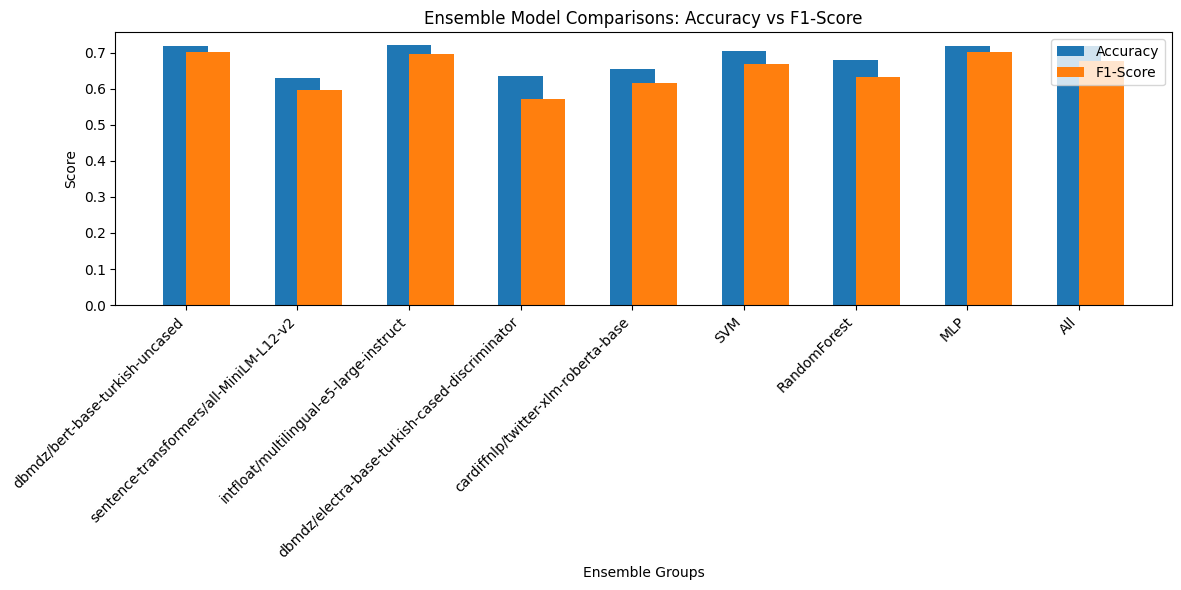

In [64]:
# Bar plot: Accuracy ve F1-Score karşılaştırması
fig, ax = plt.subplots(figsize=(12, 6))

# Accuracy ve F1-Score'u gruplar halinde ayır
accuracy_scores = comparison_df[["Group", "Accuracy"]].set_index("Group")["Accuracy"]
f1_scores = comparison_df[["Group", "F1-Score"]].set_index("Group")["F1-Score"]

# Gruplara göre barları çiz
x = range(len(comparison_df["Group"]))
ax.bar(x, accuracy_scores, width=0.4, label="Accuracy", align='center')
ax.bar(x, f1_scores, width=0.4, label="F1-Score", align='edge')

# Grafik detayları
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Group"], rotation=45, ha="right")
ax.set_title("Ensemble Model Comparisons: Accuracy vs F1-Score")
ax.set_ylabel("Score")
ax.set_xlabel("Ensemble Groups")
ax.legend()

plt.tight_layout()
plt.show()
